This project analyzes a time series on frozen dessert production and creates a forecast using an LSTM RNN model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('whitegrid')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load the data
df=pd.read_csv('/content/drive/MyDrive/FINAL_TF2_FILES/TF_2_Notebooks_and_Data/DATA/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [4]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [5]:
df.columns = ['Production']

In [6]:
df.tail()

,Production
DATE,
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632
2019-08-01,102.6085
2019-09-01,101.5866


In [7]:
# 573 rows
 
df.shape

(573, 1)

# EDA

In [8]:
# Interactive Time Series plot of Production
 
fig = px.line(df, y='Production', x=df.index, title='Production Time Series')
fig.update_layout(xaxis_title='Date')
fig.show()

In [9]:
from numpy import polyfit
def fit(X, y, degree=3):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)
def get_season(s, yearly_periods=12, degree=3):
    X = [i%(yearly_periods) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)
def get_trend(s, degree=3):
    X = list(range(len(s)))
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)

Text(0, 0.5, 'Production')

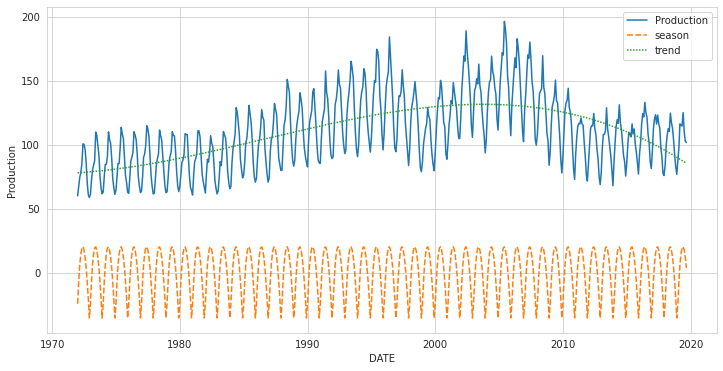

In [10]:
data = df.copy()
plt.figure(figsize=(12, 6))
data['trend'] = get_trend(data['Production'])
data['season'] = get_season(data['Production'] - data['trend'])
sns.lineplot(data=data[['Production', 'season', 'trend']])
plt.ylabel('Production')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



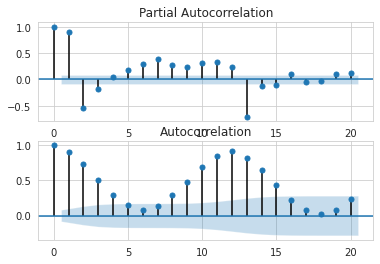

In [11]:
# correlation of each lag
import statsmodels.api as sm
fig, axes = plt.subplots(nrows=2, ncols=1)
sm.graphics.tsa.plot_pacf(data['Production'], lags=20, ax=axes[0]);
sm.graphics.tsa.plot_acf(data['Production'], lags=20, ax=axes[1]);

In [12]:
# A test for stationarity is the augmented Dickey–Fuller test
# The second return value is the p-value
# With p-values below 5% or 0.05 we would typically reject the null hypothesis, 
# and we could assume that our time-series is stationary
from statsmodels.tsa import stattools
print('Production stationarity test:', stattools.adfuller(data['Production'])[1])
print('trend stationarity test:', stattools.adfuller(data['trend'])[1])
print('season stationarity test:', stattools.adfuller(data['season'])[1])

Production stationarity test: 0.3899778705938125
trend stationarity test: 0.9830000647300499
season stationarity test: 0.0


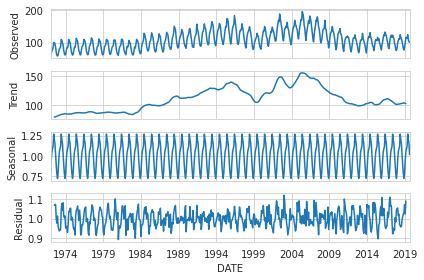

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
DecompDataAdd = seasonal_decompose(data['Production'], model='multiplicative', freq=12)
DecompDataAdd.plot();

### EDA with Dash

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [15]:
import plotly.graph_objs as go
fig2 = go.Figure([
    go.Scatter(
        name='Production',
        x=data.index,
        y=data['Production'],
        mode='lines',
        marker=dict(color='blue', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='Trend',
        x=data.index,
        y=data['trend'],
        mode='lines',
        marker=dict(color='green', size=1),
        showlegend=True
    ),
    go.Scatter(
        name='Season',
        x=data.index,
        y=data['season'],
        marker=dict(color="orange"),
        line=dict(width=1),
        mode='lines',
        showlegend=True
    )
])
fig2.update_layout(
    yaxis_title='Production',
    title='Production Time Series',
    hovermode="x"
)

In [16]:
# Dashboard with Dash
 
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig2)
])
 
app.run_server(mode='external')

Dash app running on:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



<IPython.core.display.Javascript object>

In [17]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [18]:
public_url = ngrok.connect(addr = '8050')

In [19]:
public_url

<NgrokTunnel: "http://556c-35-225-227-155.ngrok.io" -> "http://localhost:8050">

In [20]:
ngrok.kill()

# RNN Model

## Train-test Split

In [21]:
len(df)

573

In [22]:
test_size = 24

In [23]:
test_ind = len(df)- test_size # test index

In [24]:
train = df.iloc[:test_ind] # training set
test = df.iloc[test_ind:] # testing set is last 24 values

## Scale Data

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
scaler = MinMaxScaler()

In [27]:
scaler.fit(train)

MinMaxScaler()

In [28]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Time Series Generator

In [29]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [30]:
length = 24
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Create the Model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [32]:
n_features = 1

In [33]:
model = Sequential()
model.add(LSTM(115, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 115)               53820     
                                                                 
 dense (Dense)               (None, 1)                 116       
                                                                 
Total params: 53,936
Trainable params: 53,936
Non-trainable params: 0
_________________________________________________________________


In [35]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=20, batch_size=1)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [38]:
model.fit_generator(generator,epochs=25,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/25
525/525 [==============================] - 8s 12ms/step - loss: 0.0267 - val_loss: 0.0054
Epoch 2/25
525/525 [==============================] - 6s 12ms/step - loss: 0.0147 - val_loss: 0.0024
Epoch 3/25
525/525 [==============================] - 6s 12ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 4/25
525/525 [==============================] - 6s 11ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 5/25
525/525 [==============================] - 6s 12ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 6/25
525/525 [==============================] - 6s 12ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 7/25
525/525 [==============================] - 6s 11ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 8/25
525/525 [==============================] - 6s 11ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 9/25
525/525 [==============================] - 6s 11ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 10/25
525/525 [==============================] - 6s 12ms/step - loss: 0.0027 - val_lo

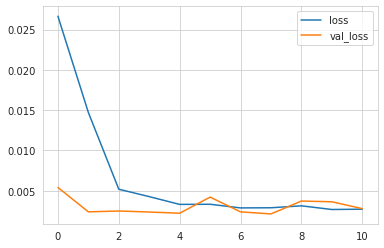

In [39]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on Test Data

In [40]:
test_predictions = []
 
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [41]:
true_predictions = scaler.inverse_transform(test_predictions)

In [42]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,88.670212
2017-11-01,77.4378,83.815495
2017-12-01,75.8118,87.435563
2018-01-01,83.4343,99.248517
2018-02-01,99.4899,109.879802
2018-03-01,107.3152,118.043442
2018-04-01,112.4309,124.608149
2018-05-01,110.3544,128.881582
2018-06-01,124.5841,128.514503


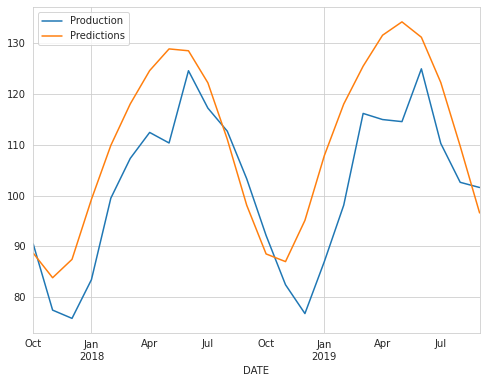

In [44]:
test.plot(figsize=(8,6))

In [45]:
from sklearn import metrics

In [46]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(test['Production'], test['Predictions'])))

RMSE: 11.942643730650408


# Forecast

In [47]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [48]:
length = 24 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [49]:
model = Sequential()
model.add(LSTM(115, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
 
 
# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.




549/549 [==============================] - 8s 12ms/step - loss: 0.0278
Epoch 2/8
549/549 [==============================] - 6s 12ms/step - loss: 0.0106
Epoch 3/8
549/549 [==============================] - 6s 11ms/step - loss: 0.0052
Epoch 4/8
549/549 [==============================] - 6s 11ms/step - loss: 0.0041
Epoch 5/8
549/549 [==============================] - 6s 11ms/step - loss: 0.0031
Epoch 6/8
549/549 [==============================] - 6s 12ms/step - loss: 0.0032
Epoch 7/8
549/549 [==============================] - 6s 11ms/step - loss: 0.0030
Epoch 8/8
549/549 [==============================] - 6s 11ms/step - loss: 0.0032


In [50]:
forecast = []
# Replace periods with forecast length
periods = 12
 
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [51]:
forecast = scaler.inverse_transform(forecast)

In [52]:
forecast_index = pd.date_range(start='2019-10-01',periods=periods,freq='MS')

In [53]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [54]:
forecast_df

,Forecast
2019-10-01,87.205437
2019-11-01,82.671691
2019-12-01,85.449916
2020-01-01,95.160930
2020-02-01,106.732400
2020-03-01,115.294060
2020-04-01,121.230643
2020-05-01,123.755749
2020-06-01,120.670332
2020-07-01,111.652436


In [55]:
Forecast = pd.concat([df, forecast_df])

In [56]:
Forecast.head()

,Production,Forecast
1972-01-01,59.9622,NaN
1972-02-01,67.0605,NaN
1972-03-01,74.2350,NaN
1972-04-01,78.1120,NaN
1972-05-01,84.7636,NaN


In [57]:
Forecast.tail()

,Production,Forecast
2020-05-01,NaN,123.755749
2020-06-01,NaN,120.670332
2020-07-01,NaN,111.652436
2020-08-01,NaN,98.979755
2020-09-01,NaN,86.428707


In [58]:
# Plot of previous and forecasted data

import plotly.graph_objects as go

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=Forecast.index, y=Forecast['Production'],
                    mode='lines',
                    name='Production'))
fig2.add_trace(go.Scatter(x=Forecast.index, y=Forecast['Forecast'],
                    mode='lines',
                    name='Forecast'))

In [59]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig2)
])
 
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [60]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [61]:
public_url = ngrok.connect(addr = '8050')

In [62]:
public_url

<NgrokTunnel: "http://e5ae-35-225-227-155.ngrok.io" -> "http://localhost:8050">

In [63]:
ngrok.kill()

# Save model and scaler

In [64]:
from google.colab import drive
 
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [65]:
from tensorflow.keras.models import load_model
import joblib

In [66]:
# Save the model
model.save('/content/drive/MyDrive/Projects/ForecastingProduction_RNN/FC_model.h5')

In [67]:
# Save the scaler
joblib.dump(scaled_full_data, '/content/drive/MyDrive/Projects/ForecastingProduction_RNN/FC_scaler.pkl')

['/content/drive/MyDrive/Projects/ForecastingProduction_RNN/FC_scaler.pkl']

# Load and run the model

In [68]:
from google.colab import drive
 
drive.mount('drive')

import pandas as pd
import numpy as np

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [69]:
df=pd.read_csv('/content/drive/MyDrive/FINAL_TF2_FILES/TF_2_Notebooks_and_Data/DATA/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)
df.columns = ['Production']

In [70]:
from tensorflow.keras.models import load_model
import joblib

In [71]:
FC_model = load_model('/content/drive/MyDrive/Projects/ForecastingProduction_RNN/FC_model.h5')

In [72]:
FC_scaler = joblib.load("/content/drive/MyDrive/Projects/ForecastingProduction_RNN/FC_scaler.pkl")

In [73]:
forecast = []
# Replace periods with forecast length
periods = 12
length = 24
n_features = 1
 
first_eval_batch = FC_scaler[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = FC_model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [74]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)
forecast = scaler.inverse_transform(forecast)

In [75]:
forecast_index = pd.date_range(start='2019-10-01',periods=periods,freq='MS')

In [76]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [77]:
forecast_df

,Forecast
2019-10-01,87.205437
2019-11-01,82.671691
2019-12-01,85.449916
2020-01-01,95.160930
2020-02-01,106.732400
2020-03-01,115.294060
2020-04-01,121.230643
2020-05-01,123.755749
2020-06-01,120.670332
2020-07-01,111.652436


In [78]:
Forecast = pd.concat([df, forecast_df])
Forecast

,Production,Forecast
1972-01-01,59.9622,NaN
1972-02-01,67.0605,NaN
1972-03-01,74.2350,NaN
1972-04-01,78.1120,NaN
1972-05-01,84.7636,NaN
...,...,...
2020-05-01,NaN,123.755749
2020-06-01,NaN,120.670332
2020-07-01,NaN,111.652436
2020-08-01,NaN,98.979755


## Deploy the forecast with Dash and ngrok

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [80]:
# Plot of previous and forecasted data

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=Forecast.index, y=Forecast['Production'],
                    mode='lines',
                    name='Production'))
fig.add_trace(go.Scatter(x=Forecast.index, y=Forecast['Forecast'],
                    mode='lines',
                    name='Forecast'))

In [81]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig)
])
 
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [82]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [83]:
public_url = ngrok.connect(addr = '8050')

In [84]:
public_url

<NgrokTunnel: "http://a343-35-225-227-155.ngrok.io" -> "http://localhost:8050">

In [85]:
ngrok.kill()